# Deep Convolutional GAN (DCGAN)

### Goal
In this notebook, you're going to create another GAN using the MNIST dataset. You will implement a Deep Convolutional GAN (DCGAN), a very successful and influential GAN model developed in 2015.

*Note: [here](https://arxiv.org/pdf/1511.06434v1.pdf) is the paper if you are interested! It might look dense now, but soon you'll be able to understand many parts of it :)*

### Learning Objectives
1.   Get hands-on experience making a widely used GAN: Deep Convolutional GAN (DCGAN).
2.   Train a powerful generative model.


![Generator architecture](dcgan-gen.png)

Figure: Architectural drawing of a generator from DCGAN from [Radford et al (2016)](https://arxiv.org/pdf/1511.06434v1.pdf).

## Getting Started

#### DCGAN
Here are the main features of DCGAN (don't worry about memorizing these, you will be guided through the implementation!):

<!-- ```
Architecture guidelines for stable Deep Convolutional GANs
• Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
convolutions (generator).
• Use BatchNorm in both the generator and the discriminator.
• Remove fully connected hidden layers for deeper architectures.
• Use ReLU activation in generator for all layers except for the output, which uses Tanh.
• Use LeakyReLU activation in the discriminator for all layers.
``` -->


*   Use convolutions without any pooling layers
*   Use batchnorm in both the generator and the discriminator
*   Don't use fully connected hidden layers
*   Use ReLU activation in the generator for all layers except for the output, which uses a Tanh activation.
*   Use LeakyReLU activation in the discriminator for all layers except for the output, which does not use an activation

You will begin by importing some useful packages and data that will help you create your GAN. You are also provided a visualizer function to help see the images your GAN will create.

In [4]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## Generator
The first component you will make is the generator. You may notice that instead of passing in the image dimension, you will pass the number of image channels to the generator. This is because with DCGAN, you use convolutions which don’t depend on the number of pixels on an image. However, the number of channels is important to determine the size of the filters.

You will build a generator using 4 layers (3 hidden layers + 1 output layer). As before, you will need to write a function to create a single block for the generator's neural network.
<!-- From the paper, we know to "[u]se batchnorm in both the generator and the discriminator" and "[u]se ReLU activation in generator for all layers except for the output, which uses Tanh." -->
Since in DCGAN the activation function will be different for the output layer, you will need to check what layer is being created. You are supplied with some tests following the code cell so you can see if you're on the right track!

At the end of the generator class, you are given a forward pass function that takes in a noise vector and generates an image of the output dimension using your neural network. You are also given a function to create a noise vector. These functions are the same as the ones from the last assignment.

<details>
<summary>
<font size="3" color="green">
<b>Optional hint for <code><font size="4">make_gen_block</font></code></b>
</font>
</summary>

1. You'll find [nn.ConvTranspose2d](https://pytorch.org/docs/master/generated/torch.nn.ConvTranspose2d.html) and [nn.BatchNorm2d](https://pytorch.org/docs/master/generated/torch.nn.BatchNorm2d.html) useful!
</details>

In [5]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Generator
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN,
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''

        #     Steps:
        #       1) Do a transposed convolution using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a ReLU activation.
        #       4) If its the final layer, use a Tanh activation after the deconvolution.

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
                #### END CODE HERE ####
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

In [6]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
'''
Test your make_gen_block() function
'''
gen = Generator()
num_test = 100

# Test the hidden block
test_hidden_noise = get_noise(num_test, gen.z_dim)
test_hidden_block = gen.make_gen_block(10, 20, kernel_size=4, stride=1)
test_uns_noise = gen.unsqueeze_noise(test_hidden_noise)
hidden_output = test_hidden_block(test_uns_noise)

# Check that it works with other strides
test_hidden_block_stride = gen.make_gen_block(20, 20, kernel_size=4, stride=2)

test_final_noise = get_noise(num_test, gen.z_dim) * 20
test_final_block = gen.make_gen_block(10, 20, final_layer=True)
test_final_uns_noise = gen.unsqueeze_noise(test_final_noise)
final_output = test_final_block(test_final_uns_noise)

# Test the whole thing:
test_gen_noise = get_noise(num_test, gen.z_dim)
test_uns_gen_noise = gen.unsqueeze_noise(test_gen_noise)
gen_output = gen(test_uns_gen_noise)

Here's the test for your generator block:

In [7]:
# UNIT TESTS
assert tuple(hidden_output.shape) == (num_test, 20, 4, 4)
assert hidden_output.max() > 1
assert hidden_output.min() == 0
assert hidden_output.std() > 0.2
assert hidden_output.std() < 1
assert hidden_output.std() > 0.5

assert tuple(test_hidden_block_stride(hidden_output).shape) == (num_test, 20, 10, 10)

assert final_output.max().item() == 1
assert final_output.min().item() == -1

assert tuple(gen_output.shape) == (num_test, 1, 28, 28)
assert gen_output.std() > 0.5
assert gen_output.std() < 0.8
print("Success!")

Success!


## Discriminator
The second component you need to create is the discriminator.

You will use 3 layers in your discriminator's neural network. Like with the generator, you will need create the function to create a single neural network block for the discriminator.
<!-- From the paper, we know that we need to "[u]se LeakyReLU activation in the discriminator for all layers." And for the LeakyReLUs, "the slope of the leak was set to 0.2" in DCGAN. -->
There are also tests at the end for you to use.
<details>
<summary>
<font size="3" color="green">
<b>Optional hint for <code><font size="4">make_disc_block</font></code></b>
</font>
</summary>

1. You'll find [nn.Conv2d](https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html), [nn.BatchNorm2d](https://pytorch.org/docs/master/generated/torch.nn.BatchNorm2d.html), and [nn.LeakyReLU](https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html) useful!
</details>

In [8]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Discriminator
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN,
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        #     Steps:
        #       1) Add a convolutional layer using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a LeakyReLU activation with slope 0.2.

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE #### #
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
                #### END CODE HERE ####
            )
        else: # Final Layer
            return nn.Sequential(
                #### START CODE HERE #### #
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
                #### END CODE HERE ####
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor,
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [9]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
'''
Test your make_disc_block() function
'''
num_test = 100

gen = Generator()
disc = Discriminator()
test_images = gen(get_noise(num_test, gen.z_dim))

# Test the hidden block
test_hidden_block = disc.make_disc_block(1, 5, kernel_size=6, stride=3)
hidden_output = test_hidden_block(test_images)

# Test the final block
test_final_block = disc.make_disc_block(1, 10, kernel_size=2, stride=5, final_layer=True)
final_output = test_final_block(test_images)

# Test the whole thing:
disc_output = disc(test_images)

Here's a test for your discriminator block:

In [10]:
# Test the hidden block
assert tuple(hidden_output.shape) == (num_test, 5, 8, 8)
# Because of the LeakyReLU slope
assert -hidden_output.min() / hidden_output.max() > 0.15
assert -hidden_output.min() / hidden_output.max() < 0.25
assert hidden_output.std() > 0.5
assert hidden_output.std() < 1

# Test the final block

assert tuple(final_output.shape) == (num_test, 10, 6, 6)
assert final_output.max() > 1.0
assert final_output.min() < -1.0
assert final_output.std() > 0.3
assert final_output.std() < 0.6

# Test the whole thing:

assert tuple(disc_output.shape) == (num_test, 1)
assert disc_output.std() > 0.25
assert disc_output.std() < 0.5
print("Success!")

Success!


## Training
Now you can put it all together!
Remember that these are your parameters:
  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   beta_1, beta_2: the momentum term
  *   device: the device type

<!-- In addition, be warned that **this runs very slowly on the default CPU**. One way to run this more quickly is to download the .ipynb and upload it to Google Drive, then open it with Google Colab, click on `Runtime -> Change runtime type` and set hardware accelerator to GPU and replace
`device = "cpu"`
with
`device = "cuda"`. The code should then run without any more changes, over 1,000 times faster.  -->


In [11]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum, which you can read more about here:
# https://distill.pub/2017/momentum/ but you don’t need to worry about it for this course!
beta_1 = 0.5
beta_2 = 0.999
device = 'cpu'

# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

Then, you can initialize your generator, discriminator, and optimizers.

In [12]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Finally, you can train your GAN!
For each epoch, you will process the entire dataset in batches. For every batch, you will update the discriminator and generator. Then, you can see DCGAN's results!

Here's roughly the progression you should be expecting. On GPU this takes about 30 seconds per thousand steps. On CPU, this can take about 8 hours per thousand steps. You might notice that in the image of Step 5000, the generator is disproprotionately producing things that look like ones. If the discriminator didn't learn to detect this imbalance quickly enough, then the generator could just produce more ones. As a result, it may have ended up tricking the discriminator so well that there would be no more improvement, known as mode collapse:
![MNIST Digits Progression](MNIST_DCGAN_Progression.png)


In [13]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

# Define the file path to save the generator weights
generator_weights_path = 'generator_epoch_{epoch}.pth'

for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()     

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

    # Save the generator weights
    torch.save(gen.state_dict(), generator_weights_path.format(epoch=epoch))

SyntaxError: invalid syntax (1308182120.py, line 16)

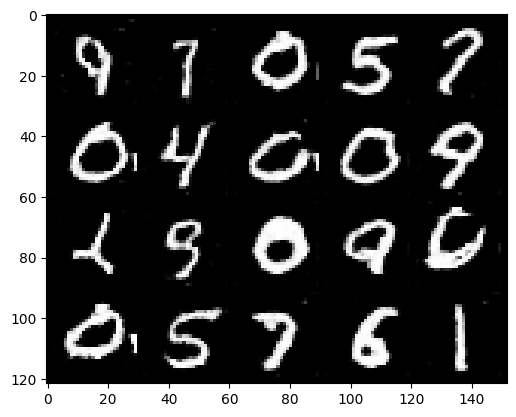

In [ ]:
## GENERATE IMAGES USING THE GENERATOR
import torch
import torchvision
import matplotlib.pyplot as plt

# Assuming z_dim is the noise dimension used during training, for example, 64
z_dim = 64

# Instantiate the generator
generator = Generator(z_dim=z_dim)

# If you have saved model weights from training, load them
generator.load_state_dict(torch.load('generator_epoch_saved_weights/generator_epoch_49.pth'))

generator.eval()  # Set the generator to evaluation mode

# Function to create noise vectors
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

# Lock the random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)

# Generate Noise Vectors
num_images = 20  # Number of images you want to generate
noise_vectors = get_noise(num_images, z_dim, device='cpu')

# Generate Images
with torch.no_grad():  # No need to compute gradients for generating images
    generated_images = generator(noise_vectors)

# Visualize Generated Images
def show_tensor_images(image_tensor, num_images=20, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2  # De-normalize images to range [0, 1]
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = torchvision.utils.make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

show_tensor_images(generated_images, num_images)

# compile all the generated images into a group and have the classifier identify them and attach appropriate labels. Do this for 50 additional GAN items

# plt.imshow(generated_images[0].permute(1,2,0), cmap="gray")




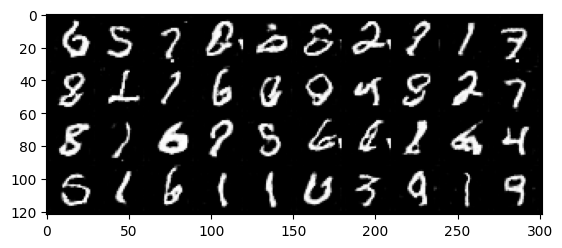

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.utils import save_image

# Assuming z_dim is the noise dimension used during training, for example, 64
z_dim = 64

# Instantiate the generator
generator = Generator(z_dim=z_dim)

generator.load_state_dict(torch.load('generator_epoch_saved_weights/generator_epoch_49.pth')) # If you have saved model weights from training, load them
generator.eval() # Set the generator to evaluation mode

# Function to create noise vectors
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

# Lock the random seed for reproducibility
random_seed = 57
torch.manual_seed(random_seed)

# Generate Noise Vectors
num_images = 40  # Number of images you want to generate
noise_vectors = get_noise(num_images, z_dim, device='cpu')

# Generate Images
with torch.no_grad():  # No need to compute gradients for generating images
    generated_images = generator(noise_vectors)

# Visualize and Save Generated Images
def show_tensor_images(image_tensor, num_images=20, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2  # De-normalize images to range [0, 1]
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = torchvision.utils.make_grid(image_unflat[:num_images], nrow=10)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

    # Save each image separately
    for i in range(num_images):
        save_image(image_unflat[i], f'dcgan_generated_images/generated_image_{i}.png')

show_tensor_images(generated_images, num_images)

# Add a CNN model to this

Changes made:
- Using Conv2D instead of Conv3D because we're using 2D images (MNIST images) not video frames of volumetric data.

## 1. **Imports**

In [14]:
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt

/Users/richardogujawa/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


WGAN-GP


## 2. **Get MNIST data**

In [15]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data
x_train = x_train.astype('float32') / 255 # because the images are in the form of lists
x_test = x_test.astype('float32') / 255

# Reshape the data to add channel dimension
x_train = np.expand_dims(x_train, axis=-1)  # Shape: (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, axis=-1)    # Shape: (10000, 28, 28, 1)

# One-hot encode the labels
y_train = to_categorical(y_train, 10) # the 10 at the end is the number of classes there are in the dataset
y_test = to_categorical(y_test, 10)

These are the results for a model without any data augmentation, do it again:
- with data aug
- with GAN
- with WGAN-WP

In [121]:
import tensorflow as tf
import cv2
import os
from PIL import Image
import numpy as np

def crop_to_subject(image):
    # Convert the image to grayscale if it isn't already
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Find the bounding box of the non-zero pixels
    non_zero_pixels = np.argwhere(gray > 0)
    if non_zero_pixels.size == 0:
        # If the image is entirely black, return the original image
        return image

    x0, y0 = non_zero_pixels.min(axis=0)
    x1, y1 = non_zero_pixels.max(axis=0) + 1  # slices are exclusive at the top

    # Crop the image using the bounding box coordinates
    cropped = gray[x0:x1, y0:y1]

    cropped = cv2.resize(cropped, (28, 28), interpolation=cv2.INTER_AREA)

    return cropped

# Convert labels to ohe
def one_hot_encode(labels, num_classes=None):
    if num_classes is None:
        num_classes = max(labels) + 1
    return tf.keras.utils.to_categorical(labels, num_classes)

def remove_entirely_black_images(x_train, y_train):
    # Find indices of images that are entirely black
    black_image_indices = np.where(np.all(x_train == 0, axis=(1, 2)))[0]

    print("Indices of entirely black images:", black_image_indices)

    # Create a mask to select all images except the black ones
    mask = np.ones(len(x_train), dtype=bool)
    mask[black_image_indices] = False

    # Filter out the black images
    x_train_filtered = x_train[mask]
    y_train_filtered = y_train[mask]

    print("Entirely black images have been removed successfully!")

    return x_train_filtered, y_train_filtered


class DataHandler:
  def __init__(self, image_height, image_width, channels):
    self.image_height = image_height
    self.image_width = image_width
    self.channels = channels
    self.original_train_data = None
    self.original_test_data = None
    self.augmented_train_data = None
    self.dcgan_train_data = None

  def load_data(self, x_train, y_train, x_test, y_test):
    x_train_filtered, y_train_filtered = remove_entirely_black_images(x_train, y_train)
    x_test_filtered, y_test_filtered = remove_entirely_black_images(x_test, y_test)
    self.original_train_data = (x_train_filtered, y_train_filtered)
    self.original_test_data = (x_test_filtered, y_test_filtered)

  def augment_data(self, reset_before_augment=False):
    if reset_before_augment:
        print('Augmented data list was reset before augmenting.')
        self.augmented_train_data = None

    if self.original_train_data is None:
        print("Error: No original training data loaded.")
        return

    augmented_train_data = []
    augmented_train_labels = []

    # For each image and label, transform the image add that and it's original label to the augmented train
    for image, label in zip(self.original_train_data[0], self.original_train_data[1]):
        # Transformations: Shift the image along the x and y axis
        shifted = cv2.warpAffine(image, np.float32([[1, 0, np.random.randint(-30, 30)], [0, 1, np.random.randint(-30, 30)]]), (image.shape[1], image.shape[0]))
        # Resize Image
        image_resized = crop_to_subject(shifted)
        # The image currently has 2 dimensions 28 x 28, but it needs to be 28 x 28 x 1 to match the original dataset
        expanded_image = np.expand_dims(image_resized, axis=-1) # the -1 inserts the new dimension at the end of the shape.
        # Add transformed image + label to augmented training data
        augmented_train_data.append(expanded_image)
        augmented_train_labels.append(label)

    self.augmented_train_data = (np.array(augmented_train_data), np.array(augmented_train_labels)) # results in something like this [(img1, label1), (img2, label2)]
    print('Data has been augmented')

  def add_dcgan_images(self, dcgan_images, dcgan_labels):
    if self.dcgan_train_data == None: 
      # This is how my data is stored --> self.original_train_data = (x_train, y_train)
      x_train_og, y_train_og = self.original_train_data

      # Ensure dcgan_images and dcgan_labels are numpy arrays
      dcgan_images = np.array(dcgan_images)
      dcgan_labels = np.array(one_hot_encode(dcgan_labels))
      
      # Combine the original and DCGAN data
      x_train_combined = np.concatenate((x_train_og, dcgan_images), axis=0)
      y_train_combined = np.concatenate((y_train_og, dcgan_labels), axis=0)

      # Shuffle the combined dataset
      # shuffle_indices = np.arange(x_train_combined.shape[0])
      # np.random.shuffle(shuffle_indices)
      # x_train_combined = x_train_combined[shuffle_indices]
      # y_train_combined = y_train_combined[shuffle_indices]

      # Update the dcgan_train_data with the combined data
      self.dcgan_train_data = (x_train_combined, y_train_combined)
    else: 
       print('Already added dcgan data to original training data.')

  # Getters
  def get_original_train_data(self):
    return self.original_train_data

  def get_original_test_data(self):
    return self.original_test_data

  def get_augmented_train_data(self):
    return self.augmented_train_data

  def get_train_and_augmented_data(self):
    if self.original_train_data is None or self.augmented_train_data is None:
        print("Error: Original or augmented train data not loaded.")
        return None 
    
    # Get the imgs and labels
    original_data, original_labels = self.original_train_data
    augmented_data, augmented_labels = self.augmented_train_data

    # Concatenate the original and augmented data
    combined_data = np.concatenate((original_data, augmented_data), axis=0)
    combined_labels = np.concatenate((original_labels, augmented_labels), axis=0)

    return combined_data, combined_labels

  def get_train_and_dcgan_data(self): 
     return self.dcgan_train_data

In [122]:
# Understanding how argwhere-min works
test = np.array([0, 0, 1, 2, 8, 39, 49, 2, 44, 0, 0])
x0 = np.argwhere(test > 0).min(axis=0)
y0 = np.argwhere(test > 0).min(axis=1) # check for all values greater than 0 and get the max index value along the cols
x1 = np.argwhere(test > 0).max(axis=0) # check for all values greater than 0 and get the max index value along the rows
y1 = np.argwhere(test > 0).max(axis=1) # check for all values greater than 0 and get the max index value along the cols

print(f"First non-zero value per row || index: {x0}, data_point: {test[x0]}")
print(f"First non-zero value per column || index: {y0}, data_point: {test[y0]}")
print(f"Last non-zero value per row || index: {x1}, data_point: {test[x1]}")
print(f"Last non-zero value per column || index: {y1}, data_point: {test[y0]}")

First non-zero value per row || index: [2], data_point: [1]
First non-zero value per column || index: [2 3 4 5 6 7 8], data_point: [ 1  2  8 39 49  2 44]
Last non-zero value per row || index: [8], data_point: [44]
Last non-zero value per column || index: [2 3 4 5 6 7 8], data_point: [ 1  2  8 39 49  2 44]


Indices of entirely black images: [ 60000  60001  60002 ... 239996 239997 239999]
Entirely black images have been removed successfully!
Indices of entirely black images: []
Entirely black images have been removed successfully!


Text(0.5, 1.0, '5')

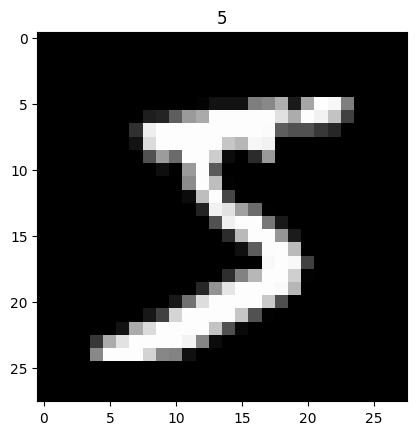

In [123]:
data_handler = DataHandler(28, 28, 1)
# load data
data_handler.load_data(x_train, y_train, x_test, y_test)
# Check out first data point
first_img = data_handler.get_original_train_data()[0][0]
first_label = data_handler.get_original_train_data()[1][0]

plt.imshow(first_img, cmap='gray')
plt.title(f'{first_label.tolist().index(1.0)}')

In [124]:
# augment data
data_handler.augment_data(reset_before_augment=True)

Augmented data list was reset before augmenting.


Data has been augmented


In [125]:
f"There are {len(data_handler.get_augmented_train_data()[0])} data points in the augmented training dataset."

'There are 147557 data points in the augmented training dataset.'

In [126]:
print(data_handler.get_train_and_augmented_data()[0])
# f"There are {len(data_handler.get_train_and_augmented_data())} data points in the augmented training dataset."

[[[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  ...

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]]


 [[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  ...

  [[0.        ]
   [0.        ]
   [0. 

## 2. Train model

In [127]:
x_test, y_test = data_handler.get_original_test_data()

In [128]:
# Get x_train, y_train to train model for each scenario
original_x_train, original_y_train = data_handler.get_original_train_data()
augmented_x_train, augmented_y_train = data_handler.get_train_and_augmented_data()

In [129]:
# utility function to plot the loss and accuracy for the trained model
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history['loss'])
    axes[0].plot(history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history['categorical_accuracy'])
    axes[1].plot(history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [130]:
"""No changes were made to the architecture of the model besides removing the third dimension of the filters as there was no longer a time dimension"""

class ModelConv2D10:
    def __init__(self):
        self.image_height = 28
        self.image_width = 28
        self.channels = 1
        self.num_classes = 10

    def define_model(self,filtersize=(3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv2D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [131]:
"""No changes were made to the architecture of the model besides removing the third dimension of the filters as there was no longer a time dimension"""

class ModelConv2D8:
    def __init__(self):
        self.image_height = 28
        self.image_width = 28
        self.channels = 1
        self.num_classes = 10

    def define_model(self, dense_neurons=64, dropout=0.25):
        model = Sequential()
        model.add(Conv2D(8, (3, 3), padding='same',
                         input_shape=(self.image_height, self.image_width, self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(16, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(32, (2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(64, (2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))

        optimiser = Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


### Model 8 with Orginal Data

In [132]:
# conv_2d8_og_data=ModelConv2D8()
# model8_og_data = conv_2d8_og_data.define_model()
# model8_og_data.summary()

In [133]:
# history8_og= model8_og_data.fit(original_x_train, original_y_train, epochs=30, batch_size=32, validation_data=(x_test, y_test)) 

In [134]:
## Save the history object to a file
import json
# with open('history8_og.json', 'w') as file:
#     json.dump(history8_og.history, file)

# Load the history object from the file
with open('saved_histories/history8_og.json', 'r') as file:
    history8_og = json.load(file)

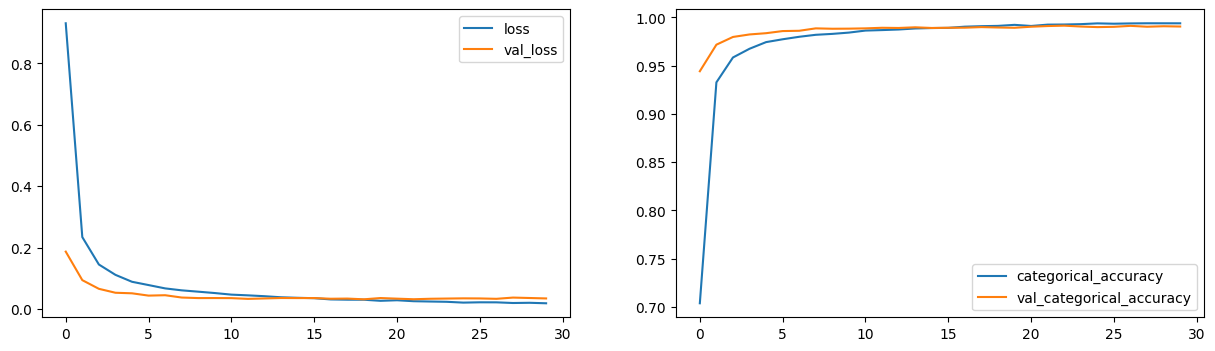

In [135]:
plot(history8_og)

In [136]:
from tensorflow.keras.models import load_model

# Save the entire model
# model8_og_data.save('model8_og_data.keras')

# Load the entire model
model8_og_data = load_model('saved_models/model8_og_data.keras')

/Users/richardogujawa/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 28 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### 2.2 Model 10 with Original Data

In [137]:
# conv_2d10_og_data = ModelConv2D8()
# model10_og_data = conv_2d10_og_data.define_model()
# model10_og_data.summary()

In [138]:
# history10_og = model10_og_data.fit(original_x_train, original_y_train, epochs=30, batch_size=32, validation_data=(x_test, y_test))

In [139]:
## Save the history object to a file
import json
# with open('history10_og.json', 'w') as file:
#     json.dump(history10_og.history, file)

# Load the history object from the file
with open('saved_histories/history10_og.json', 'r') as file:
    history10_og = json.load(file)

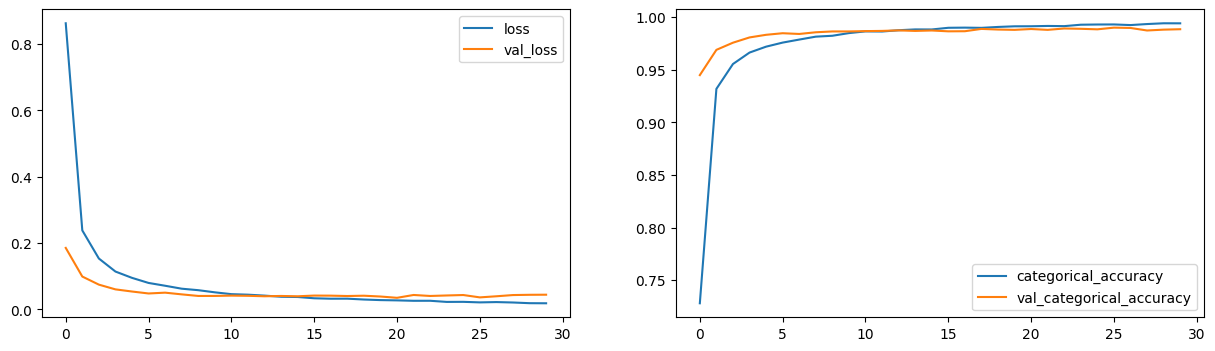

In [140]:
plot(history10_og)

In [141]:
# Save the entire model
# model10_og_data.save('model10_og_data.keras')

# Load model
model10_og_data = load_model('saved_models/model10_og_data.keras')


### 2.3 Model 8 with Augmented Data

In [142]:
## NOTE TO SELF - RERUN FROM HERE DOWN BECAUSE YOU USED THE WRONG DATA BY MISTAKE
x_train, y_train = data_handler.get_train_and_augmented_data()

In [143]:
# conv_2d8_aug_data = ModelConv2D8()
# model8_aug_data = conv_2d8_aug_data.define_model()
# model8_aug_data.summary()

In [144]:
# history8_aug = model8_aug_data.fit(augmented_x_train, augmented_y_train, epochs=30, batch_size=32, validation_data=(x_test, y_test))

In [145]:
# Save the entire model
# model8_aug_data.save('saved_models/model8_aug_data.keras')

In [146]:
## Save the history object to a file
import json
# with open('history8_aug.json', 'w') as file:
#     json.dump(history8_aug.history, file)

# Load the history object from the file
with open('saved_histories/history8_aug.json', 'r') as file:
    history8_aug = json.load(file)

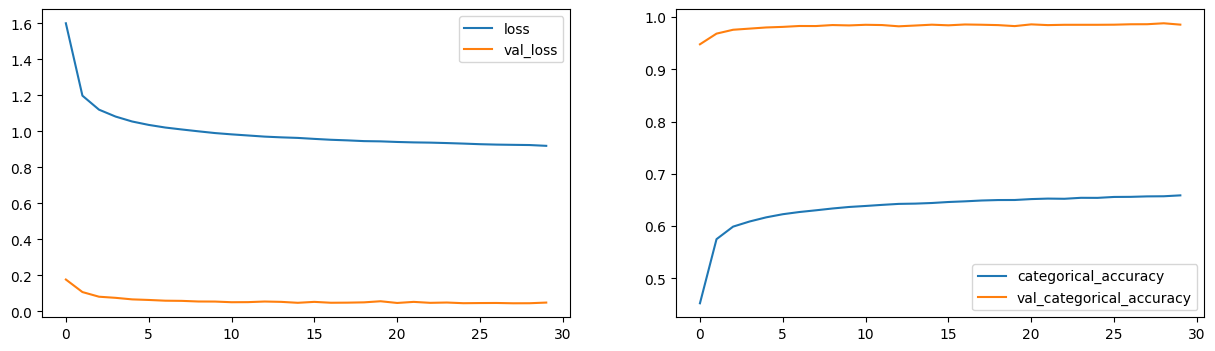

In [147]:
plot(history8_aug)

### 2.3 Model 10 with Augmented Data

In [148]:
# conv_2d10_aug_data = ModelConv2D8()
# model10_aug_data = conv_2d10_aug_data.define_model()
# model10_aug_data.summary()

In [149]:
# history10_aug = model10_aug_data.fit(augmented_x_train, augmented_y_train, epochs=30, batch_size=32, validation_data=(x_test, y_test))

In [150]:
## Save the history object to a file

# import json
# with open('history10_aug.json', 'w') as file:
#     json.dump(history10_aug.history, file)

# Load the history object from the file
with open('saved_histories/history10_aug.json', 'r') as file:
    history10_aug = json.load(file)

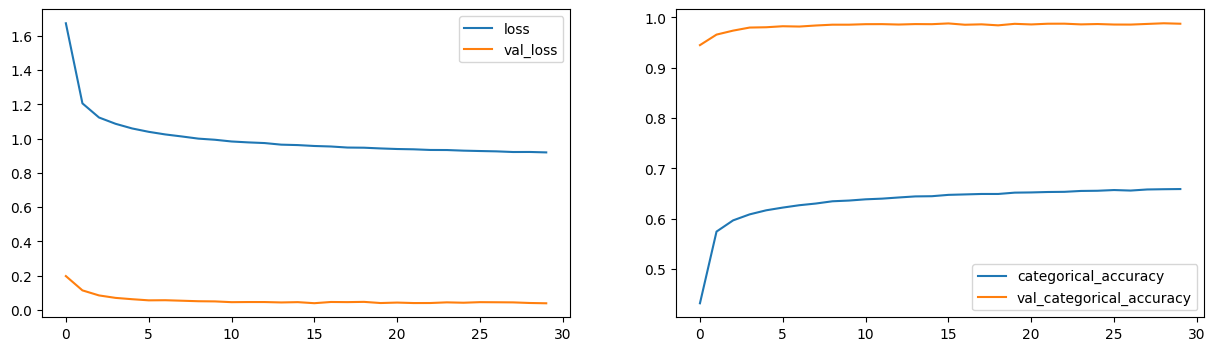

In [151]:
plot(history10_aug)

In [152]:
# Save the entire model
# model10_aug_data.save('model10_aug_data.keras')

# Load model
model10_aug_data = load_model('saved_models/model10_aug_data.keras')

### 2.3 Model 8 with DCGAN Augmented Data

In [153]:
# Step 2: Define a function to load and process generated images
def load_generated_images(folder_path):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):
            label = int(filename.split('.')[0])
            # Some filenames have _x where x is the version of the number in question, because each number has 10 versions
            if '_' in filename:
                label = int(str(filename).split('_')[0])  # Extract label from filename
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path).convert('L')  # Convert to grayscale
            image = image.resize((28, 28))  # Ensure image is 28x28
            image = np.array(image)  # Convert image to numpy array
            image = np.expand_dims(image, -1) # Add the channels dimension
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

# Step 3: Load the generated images from DCGAN
dcgan_images, dcgan_labels = load_generated_images('dcgan_generated_images')

# Step 4: Load the generated images from WGAN-GP
# wgan_images, wgan_labels = load_generated_images('')


In [154]:
# Run the method to add the images
data_handler.add_dcgan_images(dcgan_images, dcgan_labels)

In [155]:
og_x, og_y = data_handler.get_original_train_data()
dcgan_x_train, dcgan_y_train = data_handler.get_train_and_dcgan_data()

print(f"Length of original dataset:{len(og_x)}. Length of dcgan augmented dataset: {len(dcgan_x_train)}")

Length of original dataset:147557. Length of dcgan augmented dataset: 147657


In [165]:
conv_2d8_dcgan_data = ModelConv2D8()
model8_dcgan_data = conv_2d8_dcgan_data.define_model()
model8_dcgan_data.summary()

/Users/richardogujawa/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 28, 28, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 14, 14, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 7, 7, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 7, 7, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 3, 3, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 3, 3, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 21,546 (84.16 KB)

 Trainable params: 21,050 (82.23 KB)

 Non-trainable params: 496 (1.94 KB)

In [166]:
history8_dcgan = model8_dcgan_data.fit(dcgan_x_train, dcgan_y_train, epochs=30, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/30
4615/4615 ━━━━━━━━━━━━━━━━━━━━ 57s 12ms/step - categorical_accuracy: 0.2949 - loss: 2.1127 - val_categorical_accuracy: 0.1818 - val_loss: 2.1690
Epoch 2/30
4615/4615 ━━━━━━━━━━━━━━━━━━━━ 53s 11ms/step - categorical_accuracy: 0.5281 - loss: 1.3510 - val_categorical_accuracy: 0.1343 - val_loss: 2.2163
Epoch 3/30
4615/4615 ━━━━━━━━━━━━━━━━━━━━ 55s 12ms/step - categorical_accuracy: 0.5720 - loss: 1.2142 - val_categorical_accuracy: 0.1962 - val_loss: 2.2391
Epoch 4/30
4615/4615 ━━━━━━━━━━━━━━━━━━━━ 51s 11ms/step - categorical_accuracy: 0.5915 - loss: 1.1505 - val_categorical_accuracy: 0.4865 - val_loss: 2.0955
Epoch 5/30
4615/4615 ━━━━━━━━━━━━━━━━━━━━ 51s 11ms/step - categorical_accuracy: 0.6051 - loss: 1.1093 - val_categorical_accuracy: 0.4802 - val_loss: 2.1607
Epoch 6/30
4615/4615 ━━━━━━━━━━━━━━━━━━━━ 55s 12ms/step - categorical_accuracy: 0.6143 - loss: 1.0802 - val_categorical_accuracy: 0.2163 - val_loss: 2.2429
Epoch 7/30
4615/4615 ━━━━━━━━━━━━━━━━━━━━ 54s 12ms/step - catego

In [181]:
# Save the entire model
# model8_dcgan_data.save('model8_dcgan_data.keras')

# Load model
model8_dcgan_data = load_model('saved_models/model8_dcgan_data.keras')

In [183]:
## Save the history object to a file
import json

# with open('history8_dcgan.json', 'w') as file:
#     json.dump(history8_dcgan.history, file)

In [184]:
# Load the history object from the file
with open('saved_histories/history8_dcgan.json', 'r') as file:
    history8_dcgan = json.load(file)

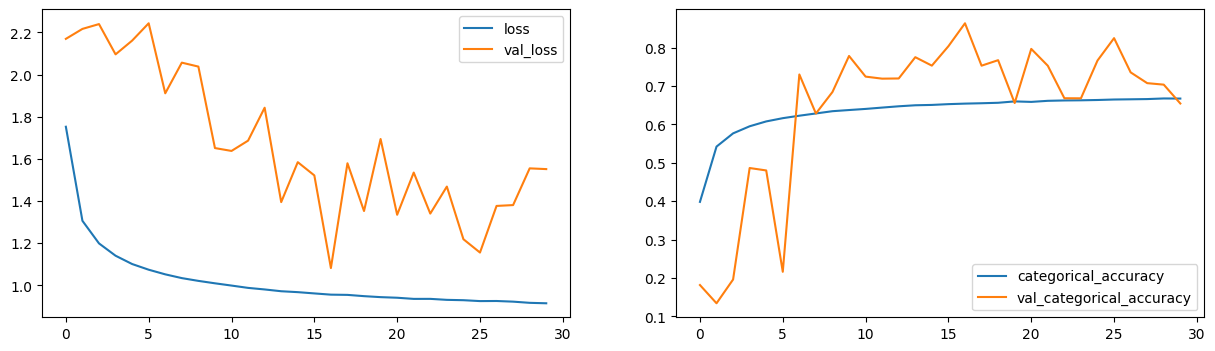

In [185]:
plot(history8_dcgan)

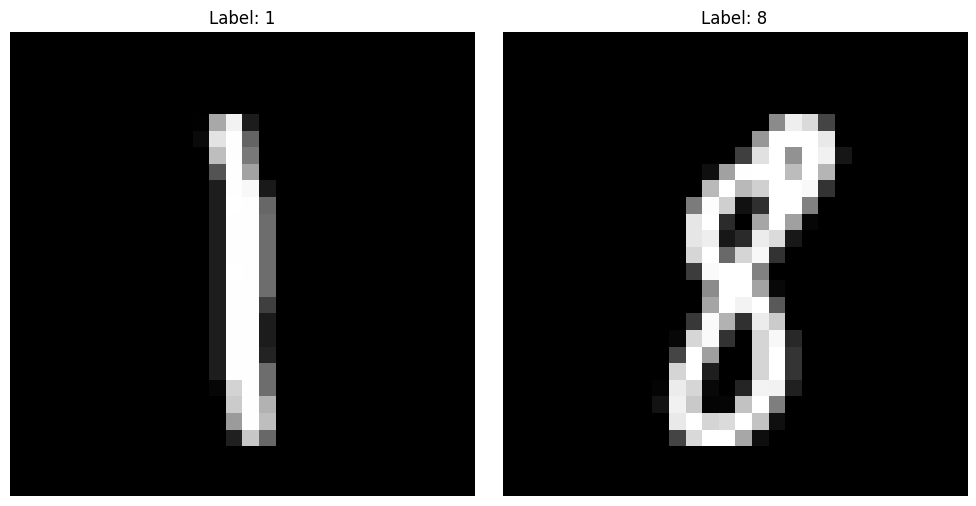

In [171]:
# Indices to display
idx = [14, 300]

# Number of images to display
num_images = len(idx)

# Create subplots
fig, axes = plt.subplots(1, num_images, figsize=(10, 5))

# Iterate through the indices and plot the images
for i, ax in enumerate(axes):
    ax.imshow(dcgan_x_train[idx[i]], cmap='gray')
    ax.set_title(f'Label: {np.argmax(dcgan_y_train[idx[i]])}')
    ax.axis('off')  # Hide the axes

plt.tight_layout()
plt.show()

There are some entirely black images, let's remove them because they're messing up the model's fitting

In [172]:
# Find indices of images that are entirely black
black_image_indices = np.where(np.all(dcgan_x_train == 0, axis=(1, 2)))[0]

print("Indices of entirely black images:", black_image_indices)
print(f"There are in total {len(black_image_indices)} of these types of images in the dataset, which is {len(black_image_indices)/len(dcgan_x_train) * 100}% of the dataset")

Indices of entirely black images: []
There are in total 0 of these types of images in the dataset, which is 0.0% of the dataset


In [173]:
# Find indices of images that are entirely black
black_image_indices = np.where(np.all(original_x_train == 0, axis=(1, 2)))[0]

print("Indices of entirely black images:", black_image_indices)
print(f"There are in total {len(black_image_indices)} of these types of images in the dataset, which is {len(black_image_indices)/len(original_x_train) * 100}% of the dataset")

Indices of entirely black images: []
There are in total 0 of these types of images in the dataset, which is 0.0% of the dataset


This is coming straight from the dataset that was loaded in from mnist, let's remove them and try again. This will be done by updating the DataHandler class to have a remove black images method.